In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Datasets/Dataset_v3.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/cannoli6254.jpg  
  inflating: dataset/donuts15288.jpg  
  inflating: dataset/apple_pie495.jpg  
  inflating: dataset/beef_tartare2048.jpg  
  inflating: dataset/churros11332.jpg  
  inflating: dataset/ceviche7602.jpg  
  inflating: dataset/frozen_yogurt22169.jpg  
  inflating: dataset/french_onion_soup20319.jpg  
  inflating: dataset/filet_mignon18038.jpg  
  inflating: dataset/escargots17300.jpg  
  inflating: dataset/chocolate_cake10256.jpg  
  inflating: dataset/chocolate_cake10242.jpg  
  inflating: dataset/escargots17314.jpg  
  inflating: dataset/gnocchi23254.jpg  
  inflating: dataset/creme_brulee13266.jpg  
  inflating: dataset/bruschetta5469.jpg  
  inflating: dataset/cannoli6240.jpg  
  inflating: dataset/apple_pie481.jpg  
  inflating: dataset/ceviche7616.jpg  
  inflating: dataset/churros11326.jpg  
  inflating: dataset/churros11440.jpg  
  inflating: dataset/fish_and_chips18727.jpg  
  inflating: data

In [4]:
df_train = pd.read_csv('/content/Food_train.csv')
# df_train["Ingredients"]=df_train["Ingredients"].apply(lambda x:x.split(","))

df_test = pd.read_csv('/content/Food_test.csv')
# df_test["Ingredients"]=df_test["Ingredients"].apply(lambda x:x.split(","))

In [5]:
ingredients = []
all_ingredients =[]
classes = 0
with open("/content/Ingredients_v2.txt", 'r') as file:
    for line in file:
        line = line.rstrip('\n')
        ingredient_list = []
        for word in line.split(","):
            word = word.strip().lower()
            ingredient_list.append(word)
            all_ingredients.append(word)
        ingredients.append(ingredient_list)

all_ingredients = list(set(all_ingredients))
classes = len(all_ingredients)

In [6]:
def append(filename):
    return "/content/dataset/"+filename

df_train["FoodImage"]=df_train["FoodImage"].apply(append)
df_test["FoodImage"]=df_test["FoodImage"].apply(append)

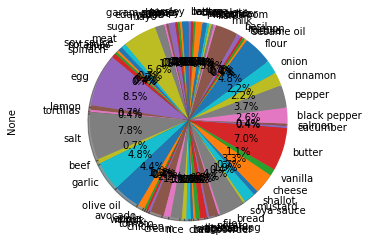

In [ ]:
fig1, ax1 = plt.subplots()
df_train.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

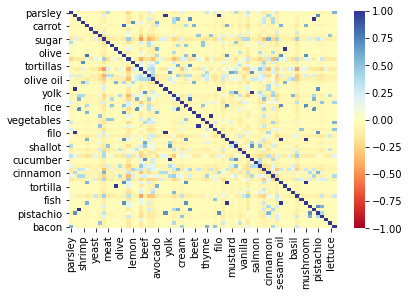

In [ ]:
import seaborn as sns
sns.heatmap(df_train.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)

In [7]:
class Food20_Dataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):
    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.df.iloc[idx,0]
    image = Image.open(self.img_dir/self.df.iloc[idx,0]).convert("RGB")
    label = torch.tensor(self.df.iloc[idx,1:].tolist() , dtype=torch.float32)
    
    if self.transforms is not None:
      image = self.transforms(image)
    return image,label
  
  def __len__(self):
    return len(self.df)

In [8]:
batch_size=128
transform = transforms.Compose([transforms.Resize((128,128)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

train_dataset = Food20_Dataset("/content/Food_train.csv" , Path("/content/dataset") , transform)
test_dataset = Food20_Dataset("/content/Food_test.csv" , Path("/content/dataset") , transform)

print(f"trainset len {len(train_dataset)} valset len {len(test_dataset)}")
dataloader = {"train":DataLoader(train_dataset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(test_dataset , shuffle=True , batch_size=batch_size)}

trainset len 20000 valset len 5000


In [9]:
# model = models.resnet50(pretrained=True) # load the pretrained model
# inception = models.inception_v3()
# resnext50_32x4d = models.resnext50_32x4d()
# wide_resnet50_2 = models.wide_resnet50_2()
# resnet_153 = models.resnet152(pretrained=True)

model = models.resnet152(pretrained=True)
num_features = model.fc.in_features # get the no of on_features in last Linear unit

print(num_features)
## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

2048


In [10]:
def create_head(num_features , number_classes ,dropout_prob=0.45 ,activation_func =nn.ReLU):
  features_lst = [num_features,num_features,num_features ,num_features,num_features,num_features,num_features,num_features ,num_features,num_features,num_features,num_features
                  , num_features//2 ,num_features//2,num_features//2,num_features//2 ,num_features//2,num_features//2,num_features//2,num_features//2,num_features//2,num_features//2,num_features//2,num_features//2
                  , num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4,num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

In [11]:

top_head = create_head(num_features , classes) # because ten classes
model.fc = top_head # replace the fully connected layer

In [12]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
#     factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
# optimizer = optim.SGD(model.parameters(), lr = 0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )
losses = []
lr = []
accuracy = []

In [13]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=50):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          preds = preds.to(torch.float32)
          
          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            scheduler.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()

             # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
      
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)
      losses.append(epoch_loss)
      accuracy.append(epoch_acc)
      lr.append(scheduler.get_last_lr())
      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [ ]:
for i in range(5):
  print("Iterations : {}".format(i))
  train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=100)

Iterations : 0


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epochs:   1%|          | 1/100 [01:31<2:30:14, 91.06s/it]

['train Loss: 0.3520 Acc: 0.0893', 'val Loss: 0.2554 Acc: 0.0031']


Epochs:   2%|▏         | 2/100 [03:03<2:29:36, 91.59s/it]

['train Loss: 0.2461 Acc: 0.0614', 'val Loss: 0.2554 Acc: 0.0646']


Epochs:   3%|▎         | 3/100 [04:36<2:29:43, 92.61s/it]

['train Loss: 0.2458 Acc: 0.0496', 'val Loss: 0.2431 Acc: 0.0595']


Epochs:   4%|▍         | 4/100 [06:12<2:29:53, 93.68s/it]

['train Loss: 0.2433 Acc: 0.0499', 'val Loss: 0.2717 Acc: 0.0420']


Epochs:   5%|▌         | 5/100 [07:47<2:29:11, 94.23s/it]

['train Loss: 0.2409 Acc: 0.0558', 'val Loss: 0.2468 Acc: 0.0345']


Epochs:   6%|▌         | 6/100 [09:22<2:28:07, 94.54s/it]

['train Loss: 0.2395 Acc: 0.0643', 'val Loss: 0.2852 Acc: 0.0429']


Epochs:   7%|▋         | 7/100 [10:58<2:27:17, 95.03s/it]

['train Loss: 0.2383 Acc: 0.0775', 'val Loss: 0.2714 Acc: 0.1049']


Epochs:   8%|▊         | 8/100 [12:33<2:25:49, 95.10s/it]

['train Loss: 0.2355 Acc: 0.0945', 'val Loss: 0.2480 Acc: 0.1275']


Epochs:   9%|▉         | 9/100 [14:08<2:23:51, 94.86s/it]

['train Loss: 0.2326 Acc: 0.1274', 'val Loss: 0.2379 Acc: 0.1032']


Epochs:  10%|█         | 10/100 [15:42<2:21:59, 94.67s/it]

['train Loss: 0.2270 Acc: 0.1592', 'val Loss: 0.2385 Acc: 0.1708']


Epochs:  11%|█         | 11/100 [17:16<2:20:21, 94.63s/it]

['train Loss: 0.2242 Acc: 0.1833', 'val Loss: 0.2267 Acc: 0.1985']


Epochs:  12%|█▏        | 12/100 [18:51<2:18:47, 94.64s/it]

['train Loss: 0.2210 Acc: 0.1965', 'val Loss: 0.2300 Acc: 0.1937']


Epochs:  13%|█▎        | 13/100 [20:26<2:17:29, 94.82s/it]

['train Loss: 0.2197 Acc: 0.2031', 'val Loss: 0.2180 Acc: 0.2377']


Epochs:  14%|█▍        | 14/100 [22:01<2:15:52, 94.80s/it]

['train Loss: 0.2183 Acc: 0.2067', 'val Loss: 0.2174 Acc: 0.1894']


Epochs:  15%|█▌        | 15/100 [23:36<2:14:11, 94.73s/it]

['train Loss: 0.2187 Acc: 0.2072', 'val Loss: 0.2135 Acc: 0.2078']


Epochs:  16%|█▌        | 16/100 [25:10<2:12:40, 94.76s/it]

['train Loss: 0.2168 Acc: 0.2106', 'val Loss: 0.2138 Acc: 0.2222']


Epochs:  17%|█▋        | 17/100 [26:45<2:11:01, 94.71s/it]

['train Loss: 0.2152 Acc: 0.2146', 'val Loss: 0.2119 Acc: 0.2177']


Epochs:  18%|█▊        | 18/100 [28:20<2:09:30, 94.77s/it]

['train Loss: 0.2133 Acc: 0.2238', 'val Loss: 0.2106 Acc: 0.1916']


Epochs:  19%|█▉        | 19/100 [29:55<2:07:55, 94.76s/it]

['train Loss: 0.2122 Acc: 0.2248', 'val Loss: 0.2087 Acc: 0.2189']


Epochs:  20%|██        | 20/100 [31:29<2:06:14, 94.69s/it]

['train Loss: 0.2108 Acc: 0.2304', 'val Loss: 0.2087 Acc: 0.2335']


Epochs:  21%|██        | 21/100 [33:05<2:05:01, 94.96s/it]

['train Loss: 0.2098 Acc: 0.2307', 'val Loss: 0.2069 Acc: 0.2237']


Epochs:  22%|██▏       | 22/100 [34:40<2:03:24, 94.93s/it]

['train Loss: 0.2091 Acc: 0.2396', 'val Loss: 0.2070 Acc: 0.2438']


Epochs:  23%|██▎       | 23/100 [36:14<2:01:43, 94.85s/it]

['train Loss: 0.2081 Acc: 0.2333', 'val Loss: 0.2060 Acc: 0.2407']


Epochs:  24%|██▍       | 24/100 [37:50<2:00:26, 95.09s/it]

['train Loss: 0.2065 Acc: 0.2441', 'val Loss: 0.2040 Acc: 0.2628']


Epochs:  25%|██▌       | 25/100 [39:24<1:58:26, 94.75s/it]

['train Loss: 0.2061 Acc: 0.2403', 'val Loss: 0.2024 Acc: 0.2460']


Epochs:  26%|██▌       | 26/100 [40:59<1:56:53, 94.78s/it]

['train Loss: 0.2056 Acc: 0.2509', 'val Loss: 0.2038 Acc: 0.2561']


Epochs:  27%|██▋       | 27/100 [42:34<1:55:27, 94.89s/it]

['train Loss: 0.2061 Acc: 0.2414', 'val Loss: 0.2032 Acc: 0.2415']


Epochs:  28%|██▊       | 28/100 [44:08<1:53:37, 94.69s/it]

['train Loss: 0.2037 Acc: 0.2487', 'val Loss: 0.2008 Acc: 0.2615']


Epochs:  29%|██▉       | 29/100 [45:42<1:51:42, 94.41s/it]

['train Loss: 0.2025 Acc: 0.2531', 'val Loss: 0.2003 Acc: 0.2701']


Epochs:  30%|███       | 30/100 [47:15<1:49:47, 94.11s/it]

['train Loss: 0.2033 Acc: 0.2531', 'val Loss: 0.2012 Acc: 0.2636']


Epochs:  31%|███       | 31/100 [48:49<1:48:14, 94.12s/it]

['train Loss: 0.2072 Acc: 0.2425', 'val Loss: 0.2047 Acc: 0.2495']


Epochs:  32%|███▏      | 32/100 [50:25<1:47:01, 94.44s/it]

['train Loss: 0.2056 Acc: 0.2485', 'val Loss: 0.2002 Acc: 0.2405']


Epochs:  33%|███▎      | 33/100 [52:00<1:45:37, 94.59s/it]

['train Loss: 0.2014 Acc: 0.2614', 'val Loss: 0.2008 Acc: 0.2694']


Epochs:  34%|███▍      | 34/100 [53:34<1:43:52, 94.43s/it]

['train Loss: 0.2005 Acc: 0.2710', 'val Loss: 0.1984 Acc: 0.2270']


Epochs:  35%|███▌      | 35/100 [55:07<1:42:02, 94.20s/it]

['train Loss: 0.2028 Acc: 0.2618', 'val Loss: 0.1976 Acc: 0.2688']


Epochs:  36%|███▌      | 36/100 [56:42<1:40:35, 94.30s/it]

['train Loss: 0.2000 Acc: 0.2757', 'val Loss: 0.1976 Acc: 0.2915']


Epochs:  37%|███▋      | 37/100 [58:17<1:39:15, 94.53s/it]

['train Loss: 0.1989 Acc: 0.2773', 'val Loss: 0.1972 Acc: 0.2714']


Epochs:  38%|███▊      | 38/100 [59:52<1:37:48, 94.66s/it]

['train Loss: 0.1989 Acc: 0.2823', 'val Loss: 0.1949 Acc: 0.2818']


Epochs:  39%|███▉      | 39/100 [1:01:27<1:36:20, 94.76s/it]

['train Loss: 0.1975 Acc: 0.2929', 'val Loss: 0.1949 Acc: 0.3075']


Epochs:  40%|████      | 40/100 [1:03:01<1:34:41, 94.70s/it]

['train Loss: 0.1976 Acc: 0.2896', 'val Loss: 0.1963 Acc: 0.2969']


Epochs:  41%|████      | 41/100 [1:04:36<1:33:03, 94.64s/it]

['train Loss: 0.1971 Acc: 0.2904', 'val Loss: 0.1940 Acc: 0.3031']


Epochs:  42%|████▏     | 42/100 [1:06:10<1:31:13, 94.37s/it]

['train Loss: 0.1981 Acc: 0.2856', 'val Loss: 0.1928 Acc: 0.3086']


Epochs:  43%|████▎     | 43/100 [1:07:43<1:29:17, 94.00s/it]

['train Loss: 0.1960 Acc: 0.2963', 'val Loss: 0.1983 Acc: 0.3214']


Epochs:  44%|████▍     | 44/100 [1:09:16<1:27:35, 93.84s/it]

['train Loss: 0.2036 Acc: 0.2699', 'val Loss: 0.1965 Acc: 0.2622']


Epochs:  45%|████▌     | 45/100 [1:10:50<1:26:01, 93.85s/it]

['train Loss: 0.1957 Acc: 0.2956', 'val Loss: 0.1924 Acc: 0.2941']


Epochs:  46%|████▌     | 46/100 [1:12:24<1:24:28, 93.86s/it]

['train Loss: 0.1948 Acc: 0.3035', 'val Loss: 0.1927 Acc: 0.2930']


Epochs:  47%|████▋     | 47/100 [1:13:58<1:22:57, 93.91s/it]

['train Loss: 0.1933 Acc: 0.3093', 'val Loss: 0.1921 Acc: 0.3224']


Epochs:  48%|████▊     | 48/100 [1:15:33<1:21:40, 94.24s/it]

['train Loss: 0.1933 Acc: 0.3168', 'val Loss: 0.1905 Acc: 0.3308']


Epochs:  49%|████▉     | 49/100 [1:17:08<1:20:09, 94.30s/it]

['train Loss: 0.1927 Acc: 0.3157', 'val Loss: 0.1912 Acc: 0.3142']


Epochs:  50%|█████     | 50/100 [1:18:42<1:18:32, 94.24s/it]

['train Loss: 0.1932 Acc: 0.3061', 'val Loss: 0.1945 Acc: 0.3138']


Epochs:  51%|█████     | 51/100 [1:20:16<1:17:01, 94.32s/it]

['train Loss: 0.1931 Acc: 0.3110', 'val Loss: 0.1920 Acc: 0.2789']


Epochs:  52%|█████▏    | 52/100 [1:21:50<1:15:19, 94.15s/it]

['train Loss: 0.1919 Acc: 0.3085', 'val Loss: 0.1893 Acc: 0.3250']


Epochs:  53%|█████▎    | 53/100 [1:23:23<1:13:34, 93.92s/it]

['train Loss: 0.1926 Acc: 0.3113', 'val Loss: 0.1908 Acc: 0.3307']


Epochs:  54%|█████▍    | 54/100 [1:24:57<1:11:55, 93.81s/it]

['train Loss: 0.1985 Acc: 0.2988', 'val Loss: 0.2062 Acc: 0.2805']


Epochs:  55%|█████▌    | 55/100 [1:26:31<1:10:21, 93.81s/it]

['train Loss: 0.1956 Acc: 0.2913', 'val Loss: 0.1926 Acc: 0.3086']


Epochs:  56%|█████▌    | 56/100 [1:28:05<1:08:56, 94.02s/it]

['train Loss: 0.1936 Acc: 0.2951', 'val Loss: 0.1939 Acc: 0.2975']


Epochs:  57%|█████▋    | 57/100 [1:29:39<1:07:25, 94.08s/it]

['train Loss: 0.1920 Acc: 0.3103', 'val Loss: 0.1930 Acc: 0.3041']


Epochs:  58%|█████▊    | 58/100 [1:31:13<1:05:51, 94.09s/it]

['train Loss: 0.1935 Acc: 0.3031', 'val Loss: 0.1900 Acc: 0.3076']


Epochs:  59%|█████▉    | 59/100 [1:32:47<1:04:16, 94.07s/it]

['train Loss: 0.1935 Acc: 0.3009', 'val Loss: 0.1924 Acc: 0.2966']


Epochs:  60%|██████    | 60/100 [1:34:21<1:02:37, 93.93s/it]

['train Loss: 0.1922 Acc: 0.3109', 'val Loss: 0.1884 Acc: 0.3134']


Epochs:  61%|██████    | 61/100 [1:35:55<1:01:01, 93.88s/it]

['train Loss: 0.1902 Acc: 0.3193', 'val Loss: 0.1869 Acc: 0.2972']


Epochs:  62%|██████▏   | 62/100 [1:37:28<59:23, 93.78s/it]  

['train Loss: 0.1899 Acc: 0.3207', 'val Loss: 0.1873 Acc: 0.3255']


Epochs:  63%|██████▎   | 63/100 [1:39:02<57:47, 93.70s/it]

['train Loss: 0.1903 Acc: 0.3234', 'val Loss: 0.1872 Acc: 0.3733']


In [ ]:
train_accuracy = []
test_accuracy = []
for i in range(len(accuracy)):
  if i%2 ==0:
    train_accuracy.append(accuracy[i])
  else:
    test_accuracy.append(accuracy[i])

print(len(train_accuracy))


1000


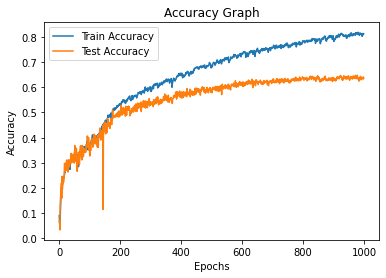

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy ,label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.title("Accuracy Graph")
plt.show()

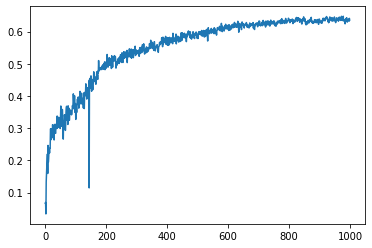

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_accuracy)
plt.show()

In [ ]:
train_loss = []
test_loss = []
for i in range(len(losses)):
  if i%2 ==0:
    train_loss.append(losses[i])
  else:
    test_loss.append(losses[i])

print(len(train_loss))

1000


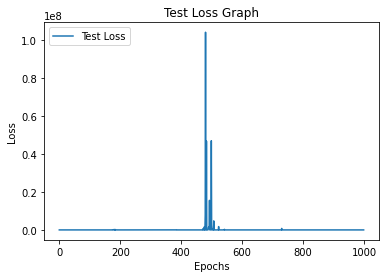

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(train_loss ,label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.title("Test Loss Graph")
plt.show()

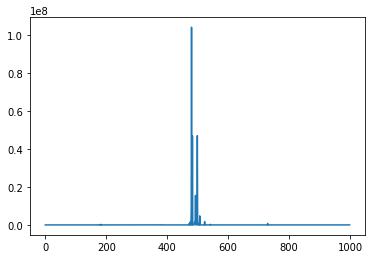

In [ ]:
plt.plot(test_loss)
plt.show()

In [ ]:
def createCheckpoint(filename=Path("./LatestCheckpointv20.35_1000.pt")):
  checkpoint = {
              'epoch': 250,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
              "losses": losses,
              "correct": accuracy,
              "lr": lr

  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()

In [ ]:
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("/content/drive/MyDrive/Checkpoints/LatestCheckpointv20.35_500.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
losses = checkpoint['losses']
lr = checkpoint['lr']
accuracy = checkpoint['correct']

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2

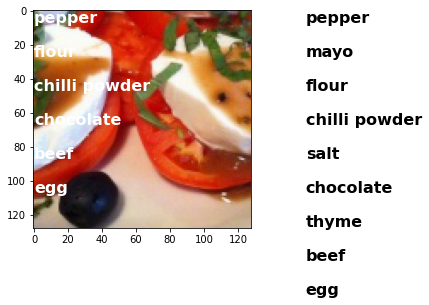

In [ ]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  np.array(all_ingredients)[np.array(actual,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  
  classes =  np.array(all_ingredients)[np.array(pred,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')

  plt.show()

visualize(image[1] , label[1].tolist() , output[1].tolist())